In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import torch.optim as optim

torch.manual_seed(1729)
x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
from torch.nn.utils.rnn import pad_sequence

def create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = [], [], []  # X1: data, X2: indexes of the motifs, y: distance to the next motif
    
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period_end = window_end_idx + forecast_period

        # If there are no more matches after the window, break
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        # Motif indexes in window, relative to the start of the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period_end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  # No match in the forecast period but exists in the future

        # Get the data window and transpose to (lookback_period, num_features)
        data_window = data[variable_indexes, idx:window_end_idx].T

        # Calculate `y`
        data_y = -1
        if next_match_in_forecast_period != -1:
            # Index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        # Append to lists
        X1.append(torch.tensor(data_window, dtype=torch.float32))  # Now with shape (lookback_period, num_features)
        X2.append(torch.tensor(motif_indexes_in_window, dtype=torch.long)) 
        y.append(data_y) 

    # Pad X2 sequences to have the same length
    X2_padded = pad_sequence(X2, batch_first=True, padding_value=-1)
    
    # Convert lists to torch tensors
    X1 = torch.stack(X1)  # Final shape: (num_samples, lookback_period, num_features)
    y = torch.tensor(y, dtype=torch.float32)

    return X1, X2_padded, y


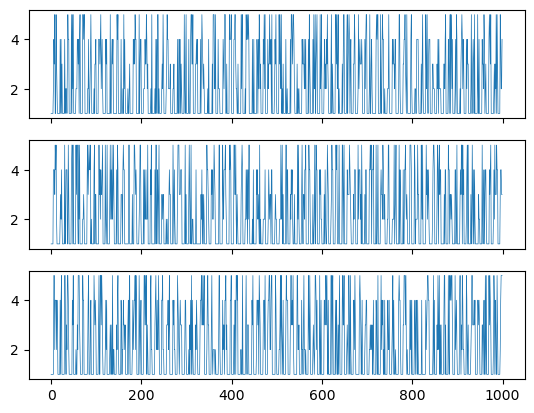

In [4]:
#load data
#fixed frequency repetitions
n = 1000
k = 3
variable_indexes = range(k)

data_scenario1 = np.genfromtxt("../data/syntheticdata/scenario1_k=3.csv", delimiter=",")
data_scenario1 = data_scenario1.astype(int)
data_scenario1 = data_scenario1.reshape((k, n))

motif_indexes_scenario1 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario1_k=3.csv", delimiter=",")
motif_indexes_scenario1= motif_indexes_scenario1.astype(int)

fig, axs = plt.subplots(k, 1, sharex=True)
for i in range(k):
    axs[i].plot(data_scenario1[i], linewidth=0.5)


In [5]:
lookback_period = 10 #window size
step = 1 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data_scenario1, variable_indexes, lookback_period, step, forecast_period, motif_indexes_scenario1)

#print one input output pair
print(X1[0])
print(X2[0])
print(y[0])

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples,)


tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [2., 4., 1.],
        [4., 4., 5.],
        [3., 4., 5.],
        [5., 3., 2.],
        [1., 5., 4.]])
tensor([ 0, -1])
tensor(5.)
X1 shape: torch.Size([980, 10, 3])
X2 shape: torch.Size([980, 2])
y shape: torch.Size([980])


In [6]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [7]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = X1  # Time series data
        self.X2 = X2  # Motif indexes data
        self.y = y    # Target values
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer for processing X1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Linear(hidden_size + X2.shape[1], output_size)
        
    def forward(self, X1, X2):
        # Initialize hidden and cell states for LSTM
        h0 = torch.zeros(self.num_layers, X1.size(0), self.hidden_size).to(X1.device)
        c0 = torch.zeros(self.num_layers, X1.size(0), self.hidden_size).to(X1.device)

        # Forward propagate LSTM
        out, _ = self.lstm(X1, (h0, c0))

        # Get the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Concatenate with X2 (motif indexes)
        out = torch.cat((out, X2.float()), dim=1)  # Concatenate along the feature dimension

        # Pass through the final fully connected layer
        out = self.fc(out)
        return out

In [10]:
# data n=1000, k=3, split 5-fold, 80% train, 20% test
# train CV1 0-141 test CV1 142-177
# train CV2 178-319 test CV2 320-355
# train CV3 356-497 test CV3 498-533
# train CV4 534-675 test CV4 676-711
# train CV5 712-853 test CV5 854-889

from sklearn.preprocessing import MinMaxScaler

# Model parameters
input_size = X1.shape[2]  # Number of features in X1
hidden_size = 50          # LSTM hidden layer size
num_layers = 2            # Number of LSTM layers
output_size = 1           # Since we are predicting a single value


# Placeholder for results
fold_results = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(BlockingTimeSeriesSplit(n_splits=5).split(X1)):
    # Create train and validation sets for each split
    X1_train, X1_val = X1[train_idx], X1[val_idx]
    X2_train, X2_val = X2[train_idx], X2[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Initialize a new scaler for each fold (only for X1)
    scaler_X1 = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler on the training data
    X1_train_reshaped = X1_train.view(-1, X1_train.shape[-1])  # Flatten for scaling
    X1_train_scaled = scaler_X1.fit_transform(X1_train_reshaped)
    X1_train = torch.tensor(X1_train_scaled, dtype=torch.float32).view(X1_train.shape)

    # Transform the validation set using the training scaler
    X1_val_reshaped = X1_val.view(-1, X1_val.shape[-1])  # Flatten for scaling
    X1_val_scaled = scaler_X1.transform(X1_val_reshaped)
    X1_val = torch.tensor(X1_val_scaled, dtype=torch.float32).view(X1_val.shape)
    
    # Create DataLoader for train and validation sets
    train_dataset = TimeSeriesDataset(X1_train, X2_train, y_train)
    val_dataset = TimeSeriesDataset(X1_val, X2_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model, loss function, and optimizer for each fold
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop for the fold
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_X1, batch_X2, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X1, batch_X2)
            loss = criterion(outputs.squeeze(), batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X1, batch_X2, batch_y in val_loader:
            outputs = model(batch_X1, batch_X2)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
    
    # Log validation loss for the fold
    avg_val_loss = val_loss / len(val_loader)
    fold_results.append(avg_val_loss)
    print(f'Fold {fold+1} Validation Loss: {avg_val_loss:.4f}')

print(fold_results)
# Display overall cross-validation performance
print(f'Mean Validation Loss across folds: {np.mean(fold_results):.4f}')
print(f'Standard Deviation of Validation Loss across folds: {np.std(fold_results):.4f}')


Fold 1, Epoch [1/200], Loss: 58.4776
Fold 1, Epoch [2/200], Loss: 56.5364
Fold 1, Epoch [3/200], Loss: 54.7685
Fold 1, Epoch [4/200], Loss: 51.4208
Fold 1, Epoch [5/200], Loss: 44.4307
Fold 1, Epoch [6/200], Loss: 34.9288
Fold 1, Epoch [7/200], Loss: 26.8182
Fold 1, Epoch [8/200], Loss: 21.6957
Fold 1, Epoch [9/200], Loss: 18.6796
Fold 1, Epoch [10/200], Loss: 16.6560
Fold 1, Epoch [11/200], Loss: 15.4552
Fold 1, Epoch [12/200], Loss: 14.7802
Fold 1, Epoch [13/200], Loss: 14.4056
Fold 1, Epoch [14/200], Loss: 14.1081
Fold 1, Epoch [15/200], Loss: 13.9823
Fold 1, Epoch [16/200], Loss: 13.8220
Fold 1, Epoch [17/200], Loss: 13.8164
Fold 1, Epoch [18/200], Loss: 13.7900
Fold 1, Epoch [19/200], Loss: 13.7070
Fold 1, Epoch [20/200], Loss: 13.5613
Fold 1, Epoch [21/200], Loss: 13.4959
Fold 1, Epoch [22/200], Loss: 13.5089
Fold 1, Epoch [23/200], Loss: 13.4873
Fold 1, Epoch [24/200], Loss: 13.4133
Fold 1, Epoch [25/200], Loss: 13.2917
Fold 1, Epoch [26/200], Loss: 13.3587
Fold 1, Epoch [27/200